In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [2]:
tenserflowdataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True, 
    image_size= (256,256), 
    batch_size=32
       )

Found 2152 files belonging to 3 classes.


In [3]:
classnames= tenserflowdataset.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
def dataset_partitions_using_tf(dataset, train_frac=0.7, val_frac=0.15, test_frac=0.15, shuffle=True, shuffle_sz=9520):
    assert (train_frac + test_frac + val_frac) == 1
    
    dataset_sz = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_sz)
    
    train_sz = int(train_frac * dataset_sz)
    test_sz = int(test_frac * dataset_sz)
    
    train_ds = dataset.take(train_sz)    
    test_ds = dataset.skip(train_sz).take(test_sz)
    val_ds = dataset.skip(train_sz).skip(test_sz)
    
    return train_ds, test_ds , val_ds

In [5]:
train_ds, test_ds, val_ds = dataset_partitions_using_tf(tenserflowdataset)

In [6]:
resz_and_resc = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
]) 


In [7]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
)

In [8]:
model = models.Sequential([
    resz_and_resc,
    layers.Conv2D(32, kernel_size = (5,5), activation='relu', input_shape=(32, 256,256, 3)),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64,  kernel_size = (5,5), activation='relu'),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((3,3)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])
model.build(input_shape=(32, 256,256, 3))

In [9]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
47/47 [==============================] - 23s 441ms/step - loss: 0.9216 - accuracy: 0.4767 - val_loss: 0.8414 - val_accuracy: 0.4665
Epoch 2/30
47/47 [==============================] - 21s 432ms/step - loss: 0.8284 - accuracy: 0.5698 - val_loss: 0.7238 - val_accuracy: 0.6222
Epoch 3/30
47/47 [==============================] - 25s 518ms/step - loss: 0.6865 - accuracy: 0.6723 - val_loss: 0.4738 - val_accuracy: 0.8011
Epoch 4/30
47/47 [==============================] - 27s 550ms/step - loss: 0.6000 - accuracy: 0.7176 - val_loss: 0.4418 - val_accuracy: 0.8352
Epoch 5/30
47/47 [==============================] - 24s 500ms/step - loss: 0.3786 - accuracy: 0.8507 - val_loss: 0.5424 - val_accuracy: 0.7774
Epoch 6/30
47/47 [==============================] - 27s 567ms/step - loss: 0.3500 - accuracy: 0.8531 - val_loss: 0.3103 - val_accuracy: 0.8636
Epoch 7/30
47/47 [==============================] - 27s 573ms/step - loss: 0.2868 - accuracy: 0.8878 - val_loss: 0.1833 - val_accuracy: 0.9176

In [15]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 2s 103ms/step - loss: 0.2271 - accuracy: 0.9312


(256, 256, 3)
first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 263ms/step
predicted label: Potato___Late_blight


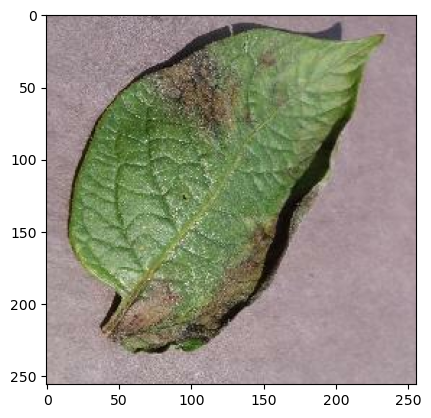

In [21]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print(first_image.shape)
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classnames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classnames[np.argmax(batch_prediction[0])])